In [1]:
from fastai.vision.all import *

In [2]:
import os; os.environ['CUDA_VISIBLE_DEVICES']='0,1'

In [3]:
path = Path('/home/user/images')

In [4]:
path.ls()

(#1000) [Path('/home/user/images/Bathygobius krefftii'),Path('/home/user/images/Oncorhynchus gorbuscha'),Path('/home/user/images/Chromis margaritifer'),Path('/home/user/images/Istigobius hoesei'),Path('/home/user/images/Abudefduf sordidus'),Path('/home/user/images/Acanthurus leucopareius'),Path('/home/user/images/Sphoeroides spengleri'),Path('/home/user/images/Orthopristis chrysoptera'),Path('/home/user/images/Etheostoma zonale'),Path('/home/user/images/Morone mississippiensis')...]

In [5]:
df_path = Path('/home/user/')

In [6]:
df = pd.read_csv(df_path/'csv/species1000-stratified.csv')

In [7]:
weights_df = pd.read_csv(df_path/'csv/species1000-weights.csv')
weights_family_df = pd.read_csv(df_path/'csv/species1000-weights-family.csv')

In [8]:
weights_df

,Specie,Count,Weight
0,Abramis brama,319,1.323439
1,Abudefduf abdominalis,221,1.910303
2,Abudefduf bengalensis,323,1.307050
3,Abudefduf saxatilis,1692,0.249514
4,Abudefduf septemfasciatus,149,2.833403
...,...,...,...
995,Zanclus cornutus,1966,0.214739
996,Zebrasoma desjardinii,166,2.543235
997,Zebrasoma flavescens,561,0.752544
998,Zebrasoma scopas,276,1.529627


# Linked-CNN

In [9]:
n_classes_f = len(set(df['Specie']))
n_classes_c = len(set(df['Family']))

In [10]:
model = resnet34
body1 = create_body(model, cut=-2)
body2 = create_body(model, cut=-2)
body1

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/user/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [11]:
head_c = create_head(512*2,n_classes_c)
head_f = create_head(512*2,n_classes_f)
head_f

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=1000, bias=False)
)

In [12]:
def custom_get_y(o):
    fine_label = o['Specie']
    coarse1_label = o['Family']
    return [coarse1_label, fine_label]

In [16]:
class Resnet34CustomModel(Module):
    def __init__(self, coarse_encoder, fine_encoder, coarse_head, fine_head):
        self.coarse_stem = coarse_encoder[:4]
        self.coarse_block1 = coarse_encoder[4]
        self.coarse_block2 = coarse_encoder[5]
        self.coarse_block3 = coarse_encoder[6]
        self.coarse_block4 = coarse_encoder[7]
        self.coarse_head = coarse_head
        
        self.fine_stem = fine_encoder[:4]
        self.fine_block1 = fine_encoder[4]
        self.fine_block2 = fine_encoder[5]
        self.fine_block3 = fine_encoder[6]
        self.fine_block4 = fine_encoder[7]
        self.fine_head = fine_head
        
    
    def forward(self, x):
        x_c = self.coarse_stem(x)
        x_f = self.fine_stem(x)
        x_f = x_f + x_c
        
        x_c = self.coarse_block1(x_c)
        x_f = self.fine_block1(x_f)
        x_f = x_f + x_c
        
        x_c = self.coarse_block2(x_c)
        x_f = self.fine_block2(x_f)
        x_f = x_f + x_c

        x_c = self.coarse_block3(x_c)
        x_f = self.fine_block3(x_f)
        x_f = x_f + x_c

        x_c = self.coarse_block4(x_c)
        x_f = self.fine_block4(x_f)
        x_f = x_f + x_c
        
        coarse1_label = self.coarse_head(x_c)
        fine_label = self.fine_head(x_f)
        
        return {
                'fine_label': fine_label,
                'coarse1_label': coarse1_label
               }

In [17]:
model = Resnet34CustomModel(body1, body2, head_c, head_f)

In [18]:
class CustomCategorize(DisplayedTransform):
    "Reversible transform of category string to `vocab` id"
    loss_func,order=CrossEntropyLossFlat(),1
    def __init__(self, vocab=None, vocab_coarse1=None, vocab_coarse2=None, sort=True, add_na=False, num_y=1):
        store_attr()
        self.vocab = None if vocab is None else CategoryMap(vocab, sort=sort, add_na=add_na)
        self.vocab_coarse1 = None if vocab_coarse1 is None else CategoryMap(vocab_coarse1, sort=sort, add_na=add_na)

    def setups(self, dsets):
        fine_dsets = [d[1] for d in dsets]
        coarse1_dsets = [d[0] for d in dsets]
        if self.vocab is None and dsets is not None: self.vocab = CategoryMap(fine_dsets, sort=self.sort, add_na=self.add_na)
        if self.vocab_coarse1 is None and dsets is not None: self.vocab_coarse1 = CategoryMap(coarse1_dsets, sort=self.sort, add_na=self.add_na)
        self.c = len(self.vocab)

    def encodes(self, o): return {'fine_label': TensorCategory(self.vocab.o2i[o[1]]),
                                  'coarse1_label': TensorCategory(self.vocab_coarse1.o2i[o[0]])
                                 }
    def decodes(self, o): return Category      (self.vocab    [o])

In [19]:
def CustomCategoryBlock(vocab=None, sort=True, add_na=False, num_y=1):
    "`TransformBlock` for single-label categorical targets"
    return TransformBlock(type_tfms=CustomCategorize(vocab=vocab, sort=sort, add_na=add_na))

In [20]:
def custom_splitter(model):
    return [params(model.coarse_stem),
            params(model.coarse_block1),
            params(model.coarse_block2),
            params(model.coarse_block3),
            params(model.coarse_block4),
            params(model.fine_stem),
            params(model.fine_block1),
            params(model.fine_block2),
            params(model.fine_block3),
            params(model.fine_block4),
            params(model.coarse_head),
            params(model.fine_head)]

In [21]:
fishes = DataBlock(blocks = (ImageBlock, CustomCategoryBlock),
                 splitter=ColSplitter(),
                 get_x = ColReader(5, pref=path),
                 get_y=custom_get_y,
                 item_tfms=RandomResizedCrop(336, min_scale=0.5),
                 batch_tfms=aug_transforms())
dls = fishes.dataloaders(df, bs=40)

In [22]:
dls.train_ds, dls.valid_ds

((#337741) [(PILImage mode=RGB size=768x1024, {'fine_label': TensorCategory(531), 'coarse1_label': TensorCategory(25)}),(PILImage mode=RGB size=1024x738, {'fine_label': TensorCategory(776), 'coarse1_label': TensorCategory(25)}),(PILImage mode=RGB size=768x1024, {'fine_label': TensorCategory(538), 'coarse1_label': TensorCategory(25)}),(PILImage mode=RGB size=768x1024, {'fine_label': TensorCategory(837), 'coarse1_label': TensorCategory(41)}),(PILImage mode=RGB size=1024x786, {'fine_label': TensorCategory(32), 'coarse1_label': TensorCategory(0)}),(PILImage mode=RGB size=1024x683, {'fine_label': TensorCategory(145), 'coarse1_label': TensorCategory(109)}),(PILImage mode=RGB size=768x1024, {'fine_label': TensorCategory(827), 'coarse1_label': TensorCategory(108)}),(PILImage mode=RGB size=1024x697, {'fine_label': TensorCategory(792), 'coarse1_label': TensorCategory(100)}),(PILImage mode=RGB size=1024x768, {'fine_label': TensorCategory(784), 'coarse1_label': TensorCategory(9)}),(PILImage mode=R

In [23]:
weights = tensor([float(weights_df[weights_df['Specie']==c]['Weight']) for c in dls.vocab]).cuda()
weights_family = tensor([float(weights_family_df[weights_family_df['Family']==c]['Weight']) for c in dls.vocab_coarse1]).cuda()

In [24]:
def loss_func(out, targ):
    return nn.CrossEntropyLoss(weight=weights)(out['fine_label'], targ['fine_label']) + \
            nn.CrossEntropyLoss(weight=weights_family)(out['coarse1_label'], targ['coarse1_label'])

In [25]:
def custom_accuracy(inp, targ, axis=-1):
    pred1,targ1 = flatten_check(inp['fine_label'].argmax(dim=axis), targ['fine_label'])
    acc1 = (pred1 == targ1).float().mean()
    return acc1

In [26]:
learn = Learner(dls, model, loss_func=loss_func, metrics=custom_accuracy,
                   splitter=custom_splitter).to_fp16()
learn.freeze()

In [27]:
learn.summary()

Resnet34CustomModel (Input shape: ['40 x 3 x 336 x 336'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               40 x 64 x 168 x 168  9,408      False     
________________________________________________________________
BatchNorm2d          40 x 64 x 168 x 168  128        True      
________________________________________________________________
ReLU                 40 x 64 x 168 x 168  0          False     
________________________________________________________________
MaxPool2d            40 x 64 x 84 x 84    0          False     
________________________________________________________________
Conv2d               40 x 64 x 84 x 84    36,864     False     
________________________________________________________________
BatchNorm2d          40 x 64 x 84 x 84    128        True      
________________________________________________________________
ReLU                 40 x 64 x 84 x 84    0          False     
________________________________________

In [28]:
learn.fit(1, 3e-3)

epoch,train_loss,valid_loss,custom_accuracy,time
0,8.329098,7.087303,0.378358,30:09


In [29]:
learn.save('species1000-linkedcnn-resnet34-fepochs1-uepochs0')

Path('models/species1000-linkedcnn-resnet34-fepochs1-uepochs0.pth')

In [30]:
learn.unfreeze()

In [31]:
def continue_training(pth_filename):
    learn = Learner(dls, model, loss_func=loss_func, metrics=custom_accuracy,
                   splitter=custom_splitter).to_fp16()
    learn.load(pth_filename)
    learn.unfreeze()
    return learn

SuggestedLRs(lr_min=7.585775847473997e-08, lr_steep=3.630780702224001e-05)

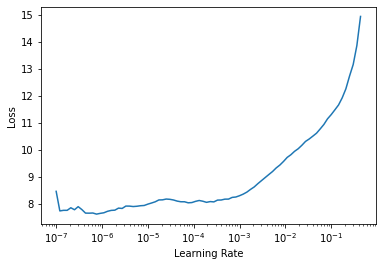

In [32]:
learn.lr_find()

In [33]:
learn.fit(5, slice(1e-6,1e-4))
learn.save('species1000-linkedcnn-resnet50-fepochs1-uepochs5')

epoch,train_loss,valid_loss,custom_accuracy,time
0,5.672403,4.662562,0.520963,36:17
1,4.938990,4.030419,0.554088,36:18
2,4.553858,3.669816,0.576555,36:23
3,4.348161,3.399161,0.599034,36:16
4,4.093227,3.255038,0.604256,36:20


Path('models/species1000-linkedcnn-resnet50-fepochs1-uepochs5.pth')

In [34]:
learn.fit(5, slice(1e-6,1e-4))
learn.save('species1000-linkedcnn-resnet50-fepochs1-uepochs10')

epoch,train_loss,valid_loss,custom_accuracy,time
0,3.826075,3.076325,0.624153,36:20
1,3.628837,2.998527,0.626332,36:20
2,3.492621,2.861937,0.640864,36:30
3,3.316508,2.779907,0.646253,36:19
4,3.201189,2.702183,0.655550,36:21


Path('models/species1000-linkedcnn-resnet50-fepochs1-uepochs10.pth')

In [ ]:
learn = continue_training('species1000-linkedcnn-resnet50-fepochs1-uepochs10')

In [35]:
learn.fit(5, slice(1e-6,1e-4))
learn.save('species1000-linkedcnn-resnet50-fepochs1-uepochs15')

epoch,train_loss,valid_loss,custom_accuracy,time
0,2.976977,2.655185,0.659328,36:19
1,2.905084,2.589010,0.664823,36:15
2,2.766506,2.573512,0.668210,36:05
3,2.953994,2.505542,0.669631,36:03
4,2.700699,2.473036,0.673552,36:04


Path('models/species1000-linkedcnn-resnet50-fepochs1-uepochs15.pth')

In [36]:
learn.export('species1000-linkedcnn-resnet50-fepochs1-uepochs15')

In [37]:
learn.fit(5, slice(1e-6,1e-4))
learn.save('species1000-linkedcnn-resnet50-fepochs1-uepochs20')

epoch,train_loss,valid_loss,custom_accuracy,time
0,2.634895,2.459136,0.682458,36:10
1,2.609674,2.453435,0.678336,36:04
2,2.364790,2.608629,0.683370,36:04
3,2.478427,2.652895,0.683488,36:07
4,2.432183,2.430915,0.694419,36:00


Path('models/species1000-linkedcnn-resnet50-fepochs1-uepochs20.pth')